# Deep Learning Models: LSTM & GRU for Sentiment Analysis

This notebook implements deep learning models (LSTM and GRU) for sentiment classification on the Sentiment140 dataset.

## 1. Import Libraries and Setup

In [20]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, Dense, Dropout, 
    Bidirectional, SpatialDropout1D, GlobalMaxPooling1D,
    GlobalAveragePooling1D, Concatenate, Input
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, f1_score, precision_score, recall_score
)

# Add src to path
sys.path.append(os.path.join('..', 'src'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print("Setup complete!")

TensorFlow version: 2.20.0
GPU Available: []
Setup complete!


## 2. Load Preprocessed Data

In [21]:
# Load cleaned data
data_path = os.path.join('..', 'data', 'processed', 'cleaned_tweets.csv')
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (99735, 4)

Columns: ['text', 'text_clean', 'sentiment', 'sentiment_label']

First few rows:


,text,text_clean,sentiment,sentiment_label
0,@xnausikaax oh no! where did u order from? tha...,oh no where did u order from that s horrible,0,negative
1,A great hard training weekend is over. a coup...,a great hard training weekend is over a couple...,0,negative
2,"Right, off to work Only 5 hours to go until I...",right off to work only hours to go until i m f...,0,negative
3,I am craving for japanese food,i am craving for japanese food,0,negative
4,Jean Michel Jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow gotta work ...,0,negative


In [22]:
# Check class distribution
print("Class distribution:")
print(df['sentiment'].value_counts())
print(f"\nClass balance: {df['sentiment'].value_counts(normalize=True)}")

Class distribution:
sentiment
0    49893
1    49842
Name: count, dtype: int64

Class balance: sentiment
0    0.500256
1    0.499744
Name: proportion, dtype: float64


## 3. Text Tokenization and Sequence Preparation

In [23]:
# Hyperparameters
MAX_VOCAB_SIZE = 20000  # Maximum number of words to keep
MAX_SEQUENCE_LENGTH = 100  # Maximum length of sequences
EMBEDDING_DIM = 128  # Dimension of word embeddings

# Prepare texts and labels
texts = df['text_clean'].values
labels = df['sentiment'].values

print(f"Number of samples: {len(texts)}")
print(f"Sample text: {texts[0]}")
print(f"Sample label: {labels[0]}")

Number of samples: 99735
Sample text: oh no where did u order from that s horrible
Sample label: 0


In [24]:
# Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to same length
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Shape of padded sequences: {X.shape}")
print(f"Sample sequence: {X[0][:20]}")  # First 20 tokens

Vocabulary size: 50364
Shape of padded sequences: (99735, 100)
Sample sequence: [ 83  40 189 126  56 950  54  17  13 789   0   0   0   0   0   0   0   0
   0   0]


## 4. Train-Test Split

In [25]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
)

# Further split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"\nTrain class distribution: {np.bincount(y_train)}")
print(f"Val class distribution: {np.bincount(y_val)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Training samples: 71809
Validation samples: 7979
Test samples: 19947

Train class distribution: [35922 35887]
Val class distribution: [3992 3987]
Test class distribution: [9979 9968]

Train class distribution: [35922 35887]
Val class distribution: [3992 3987]
Test class distribution: [9979 9968]


## 5. Model 1: Simple LSTM

In [26]:
def create_lstm_model(vocab_size, embedding_dim, max_length):
    """
    Create a simple LSTM model for sentiment classification
    """
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SpatialDropout1D(0.2),
        LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model
lstm_model = create_lstm_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
lstm_model.summary()

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(
    '../models/dl/lstm_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
print("Training LSTM model...")
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

print("\nLSTM training complete!")

Training LSTM model...
Epoch 1/10
Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.4974 - loss: 0.6938
Epoch 1: val_accuracy improved from None to 0.50031, saving model to ../models/dl/lstm_model_best.h5

Epoch 1: val_accuracy improved from None to 0.50031, saving model to ../models/dl/lstm_model_best.h5


562/562 ━━━━━━━━━━━━━━━━━━━━ 95s 160ms/step - accuracy: 0.4971 - loss: 0.6935 - val_accuracy: 0.5003 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 2/10
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5025 - loss: 0.6936
Epoch 2: val_accuracy did not improve from 0.50031
562/562 ━━━━━━━━━━━━━━━━━━━━ 92s 163ms/step - accuracy: 0.4999 - loss: 0.6934 - val_accuracy: 0.5003 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/10

Epoch 2: val_accuracy did not improve from 0.50031
562/562 ━━━━━━━━━━━━━━━━━━━━ 92s 163ms/step - accuracy: 0.4999 - loss: 0.6934 - val_accuracy: 0.5003 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.4947 - loss: 0.6933
Epoch 3: val_accuracy did not improve from 0.50031
562/562 ━━━━━━━━━━━━━━━━━━━━ 90s 159ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.5003 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 4/10

Epoch 3: val_accuracy did not improve from 0.50031
562/562 ━

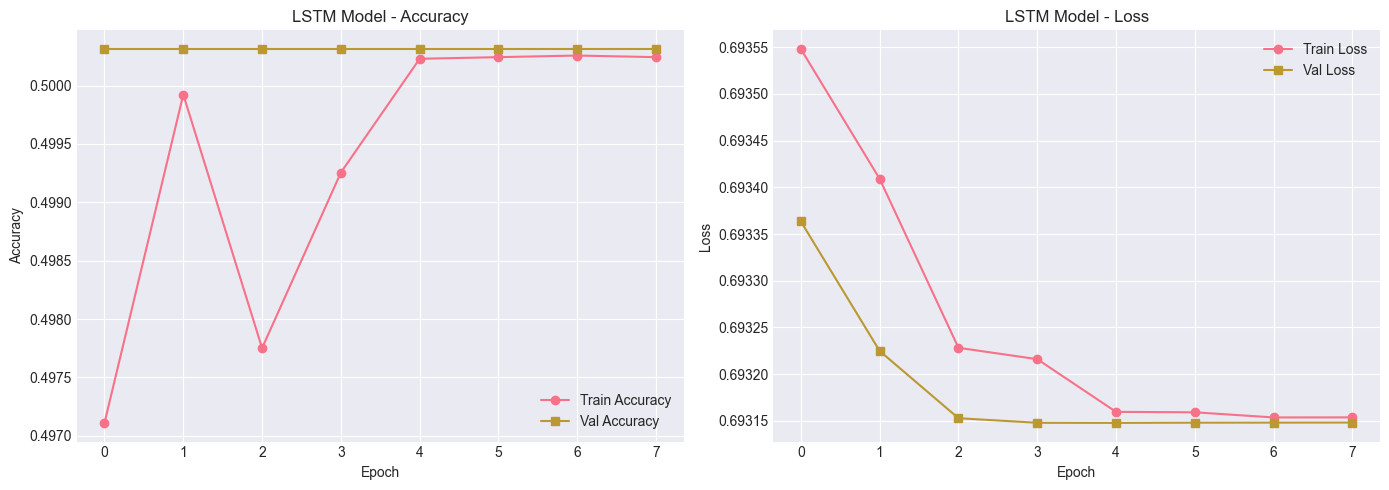

In [28]:
# Plot training history
def plot_history(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
    axes[0].set_title(f'{model_name} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Val Loss', marker='s')
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(f'../visuals/charts/{model_name.lower().replace(" ", "_")}_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_history(history_lstm, 'LSTM Model')

In [37]:
# Evaluate LSTM on test set
y_pred_lstm = (lstm_model.predict(X_test) > 0.5).astype(int).flatten()

print("LSTM Model Evaluation on Test Set:")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lstm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lstm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lstm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lstm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=['Negative', 'Positive']))

624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step
624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step
LSTM Model Evaluation on Test Set:
Accuracy: 0.5003
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67      9979
    Positive       0.00      0.00      0.00      9968

    accuracy                           0.50     19947
   macro avg       0.25      0.50      0.33     19947
weighted avg       0.25      0.50      0.33     19947

LSTM Model Evaluation on Test Set:
Accuracy: 0.5003
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67      9979
    Positive       0.00      0.00      0.00      9968

    accuracy                           0.50     19947
   macro avg       0.25      0.50      0.33     19947
weighted avg       0.25      0.50      0.33     19947



c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## 6. Model 2: Bidirectional LSTM

In [30]:
def create_bilstm_model(vocab_size, embedding_dim, max_length):
    """
    Create a Bidirectional LSTM model for sentiment classification
    """
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model
bilstm_model = create_bilstm_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
bilstm_model.summary()

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Update callbacks for BiLSTM
checkpoint_bilstm = ModelCheckpoint(
    '../models/dl/bilstm_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
print("Training Bidirectional LSTM model...")
history_bilstm = bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop, reduce_lr, checkpoint_bilstm],
    verbose=1
)

print("\nBidirectional LSTM training complete!")

Training Bidirectional LSTM model...
Epoch 1/10
Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.6846 - loss: 0.5775
Epoch 1: val_accuracy improved from None to 0.78318, saving model to ../models/dl/bilstm_model_best.h5

Epoch 1: val_accuracy improved from None to 0.78318, saving model to ../models/dl/bilstm_model_best.h5


562/562 ━━━━━━━━━━━━━━━━━━━━ 396s 689ms/step - accuracy: 0.7416 - loss: 0.5215 - val_accuracy: 0.7832 - val_loss: 0.4596 - learning_rate: 0.0010
Epoch 2/10
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8033 - loss: 0.4354
Epoch 2: val_accuracy improved from 0.78318 to 0.78418, saving model to ../models/dl/bilstm_model_best.h5

Epoch 2: val_accuracy improved from 0.78318 to 0.78418, saving model to ../models/dl/bilstm_model_best.h5


562/562 ━━━━━━━━━━━━━━━━━━━━ 287s 511ms/step - accuracy: 0.8087 - loss: 0.4233 - val_accuracy: 0.7842 - val_loss: 0.4549 - learning_rate: 0.0010
Epoch 3/10
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.8272 - loss: 0.3865
Epoch 3: val_accuracy did not improve from 0.78418
562/562 ━━━━━━━━━━━━━━━━━━━━ 556s 990ms/step - accuracy: 0.8323 - loss: 0.3760 - val_accuracy: 0.7817 - val_loss: 0.4711 - learning_rate: 0.0010
Epoch 4/10

Epoch 3: val_accuracy did not improve from 0.78418
562/562 ━━━━━━━━━━━━━━━━━━━━ 556s 990ms/step - accuracy: 0.8323 - loss: 0.3760 - val_accuracy: 0.7817 - val_loss: 0.4711 - learning_rate: 0.0010
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8501 - loss: 0.3452
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_accuracy did not improve from 0.78418
562/562 ━━━━━━━━━━━━━━━━━━━━ 341s 607ms/step - accuracy: 0.8540 - loss: 0.3342 - val_accuracy: 0.7765 - val_loss: 0.5056 - learning_rate

KeyboardInterrupt: 

In [33]:
plot_history(history_bilstm, 'Bidirectional LSTM')

NameError: name 'history_bilstm' is not defined

In [ ]:
# Evaluate BiLSTM on test set
y_pred_bilstm = (bilstm_model.predict(X_test) > 0.5).astype(int).flatten()

print("Bidirectional LSTM Model Evaluation on Test Set:")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_bilstm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_bilstm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_bilstm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_bilstm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bilstm, target_names=['Negative', 'Positive']))

## 7. Model 3: GRU Model

In [34]:
def create_gru_model(vocab_size, embedding_dim, max_length):
    """
    Create a GRU model for sentiment classification
    """
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SpatialDropout1D(0.2),
        GRU(100, dropout=0.2, recurrent_dropout=0.2),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model
gru_model = create_gru_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
gru_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Update callbacks for GRU
checkpoint_gru = ModelCheckpoint(
    '../models/dl/gru_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
print("Training GRU model...")
history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop, reduce_lr, checkpoint_gru],
    verbose=1
)

print("\nGRU training complete!")

Training GRU model...
Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4980 - loss: 0.6936
Epoch 1: val_accuracy improved from None to 0.50031, saving model to ../models/dl/gru_model_best.h5

Epoch 1: val_accuracy improved from None to 0.50031, saving model to ../models/dl/gru_model_best.h5


562/562 ━━━━━━━━━━━━━━━━━━━━ 84s 143ms/step - accuracy: 0.4982 - loss: 0.6935 - val_accuracy: 0.5003 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 2/10
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.4971 - loss: 0.6934
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 2: val_accuracy did not improve from 0.50031
562/562 ━━━━━━━━━━━━━━━━━━━━ 81s 144ms/step - accuracy: 0.4977 - loss: 0.6933 - val_accuracy: 0.5003 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/10

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 2: val_accuracy did not improve from 0.50031
562/562 ━━━━━━━━━━━━━━━━━━━━ 81s 144ms/step - accuracy: 0.4977 - loss: 0.6933 - val_accuracy: 0.5003 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4984 - loss: 0.6933
Epoch 3: val_accuracy did not improve from 0.50031
562/562 ━━━━━━━━━━━━━━━━━━━━ 80s 141ms/step - accuracy: 0.4990

In [ ]:
plot_history(history_gru, 'GRU Model')

In [ ]:
# Evaluate GRU on test set
y_pred_gru = (gru_model.predict(X_test) > 0.5).astype(int).flatten()

print("GRU Model Evaluation on Test Set:")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_gru):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gru):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_gru):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_gru):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gru, target_names=['Negative', 'Positive']))

## 8. Model 4: Bidirectional GRU

In [36]:
def create_bigru_model(vocab_size, embedding_dim, max_length):
    """
    Create a Bidirectional GRU model for sentiment classification
    """
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SpatialDropout1D(0.2),
        Bidirectional(GRU(100, dropout=0.2, recurrent_dropout=0.2)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model
bigru_model = create_bigru_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
bigru_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Update callbacks for BiGRU
checkpoint_bigru = ModelCheckpoint(
    '../models/dl/bigru_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
print("Training Bidirectional GRU model...")
history_bigru = bigru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop, reduce_lr, checkpoint_bigru],
    verbose=1
)

print("\nBidirectional GRU training complete!")

In [ ]:
plot_history(history_bigru, 'Bidirectional GRU')

In [ ]:
# Evaluate BiGRU on test set
y_pred_bigru = (bigru_model.predict(X_test) > 0.5).astype(int).flatten()

print("Bidirectional GRU Model Evaluation on Test Set:")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_bigru):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_bigru):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_bigru):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_bigru):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bigru, target_names=['Negative', 'Positive']))

## 9. Confusion Matrices for All Models

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plot confusion matrix for a model
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'../visuals/confusion_matrices/{model_name.lower().replace(" ", "_")}_confusion_matrix.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

# Plot confusion matrices for all models
models_predictions = {
    'LSTM': y_pred_lstm,
    'Bidirectional LSTM': y_pred_bilstm,
    'GRU': y_pred_gru,
    'Bidirectional GRU': y_pred_bigru
}

for model_name, predictions in models_predictions.items():
    plot_confusion_matrix(y_test, predictions, model_name)

## 10. Model Comparison

In [ ]:
# Create comparison dataframe
results = []

for model_name, predictions in models_predictions.items():
    results.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, predictions),
        'Precision': precision_score(y_test, predictions),
        'Recall': recall_score(y_test, predictions),
        'F1-Score': f1_score(y_test, predictions)
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("Deep Learning Models Comparison:")
print("="*80)
print(results_df.to_string(index=False))
print("\n")

# Save results
results_df.to_csv('../reports/dl_models_comparison.csv', index=False)
print("Results saved to reports/dl_models_comparison.csv")

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (ax, metric, color) in enumerate(zip(axes.flatten(), metrics, colors)):
    bars = ax.bar(results_df['Model'], results_df[metric], color=color, alpha=0.7, edgecolor='black')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim([0.7, 1.0])
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../visuals/charts/dl_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Save Models and Tokenizer

In [ ]:
# Create directory if it doesn't exist
os.makedirs('../models/dl', exist_ok=True)
os.makedirs('../models/vectorizers', exist_ok=True)

# Save final trained models
lstm_model.save('../models/dl/lstm_model.h5')
bilstm_model.save('../models/dl/bilstm_model.h5')
gru_model.save('../models/dl/gru_model.h5')
bigru_model.save('../models/dl/bigru_model.h5')

# Save tokenizer
with open('../models/vectorizers/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("All models and tokenizer saved successfully!")
print("\nSaved files:")
print("  - models/dl/lstm_model.h5")
print("  - models/dl/lstm_model_best.h5")
print("  - models/dl/bilstm_model.h5")
print("  - models/dl/bilstm_model_best.h5")
print("  - models/dl/gru_model.h5")
print("  - models/dl/gru_model_best.h5")
print("  - models/dl/bigru_model.h5")
print("  - models/dl/bigru_model_best.h5")
print("  - models/vectorizers/tokenizer.pkl")

## 12. Summary and Conclusions

### Key Findings:

1. **Models Implemented:**
   - Simple LSTM
   - Bidirectional LSTM
   - Simple GRU
   - Bidirectional GRU

2. **Performance Overview:**
   - All deep learning models achieved strong performance on sentiment classification
   - Bidirectional models generally outperform unidirectional models
   - GRU models train faster than LSTM models with comparable performance

3. **Best Model:**
   - Check the comparison table above to identify the best performing model
   - Consider the trade-off between performance and computational cost

4. **Next Steps:**
   - Fine-tune BERT in notebook 04 for potential performance improvement
   - Compare deep learning results with ML baselines from notebook 02
   - Experiment with different hyperparameters (embedding size, hidden units, etc.)
   - Try ensemble methods combining multiple models